**Poisson equation in 1D with hard boundary conditions**

Retyped by Theodoret Putra Agatho on 7 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.dirichlet.1d.exactbc.html)

In [1]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 9.8 MB/s eta 0:00:00


**Problem setup**

We will solve a Poisson equation:

\begin{align}
        -\Delta u = \sum_{i=1}^4 i \text{ sin} (ix) + 8 \text{sin} (8x), x \in [0, \pi]
    \end{align}

with the Dirichlet boundary conditions

\begin{align}
        u(x = 0) = 0, u (x = \pi) = \pi.
    \end{align}

The exact solution is $u(x) = x + \sum_{i=1}^4 \frac{\text{sin} (ix)}{i} + \frac{\text{sin} (8x)}{8}$.

**Implementation**

This description goes through the implementation of a solver for the above described Poisson equation step-by-step.

First, the DeepXDE, NumPy (`np`), and TensorFlow(`tf`) modules are imported.

In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

We begin by defining a computational geometry. We can use a built-in class `Interval` as follows.

In [3]:
geom = dde.geometry.Interval(0, np.pi)

Next, we express the PDE residual of the Poisson equation.

In [4]:
def pde(x, y):
  dy_xx = dde.grad.hessian(y, x)
  summation = sum([i * tf.sin(i * x) for i in range(1, 5)])
  return -dy_xx - summation - 8 * tf.sin(8 * x)

The first argument to `pde` is the network input, i.e., the $x$-coordinate. The second argument is the network output, i.e., the solution $u(x)$, but here we use `y` as the name of the variable.

Next, the reference solution `func` is defined as the following.

In [5]:
def func(x):
  summation = sum([np.sin(i * x) / i for i in range(1, 5)])
  return x + summation + np.sin(8 * x) / 8

Now, we have specified the geometry and PDE residual. We then define the PDE problem as following.

In [6]:
data = dde.data.PDE(geom, pde, [], num_domain=64, solution=func, num_test=400)

The number 64 is the number of training residual points sampled inside the domain. The argument `solution=func` is the reference solution to compute the error of our solution, and can be ignored if we don't have a reference solution. We use 400 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 50.

In [7]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Next, we define the transformation of the output and apply it to the network. When $x = 0$, the boundary condition $u(x = 0) = 0$ is satisfied. When $x = \pi$, the boundary condition $u(x = \pi) = \pi$ is satisfied. This demosntrates that both ends of the boundary constraint are hard conditions.

In [8]:
def output_transform(x, y):
  return x * (np.pi - x) * y + x

net.apply_output_transform(output_transform)

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate. We also implement a learning rate decay to reduce overfitting of the model.

In [10]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-4, decay = ("inverse time", 1000, 0.3), metrics=["l2 relative error"])

Compiling model...
'compile' took 0.516622 s



We also compute the $L^2$ relative error as a metric during training.

We then train the model for 30000 iterations.

In [11]:
losshistory, train_state = model.train(iterations=30000)

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.45e+01]    [4.46e+01]    [4.70e-01]    
1000      [2.92e+01]    [2.93e+01]    [8.07e-02]    
2000      [1.20e+01]    [1.23e+01]    [3.20e-02]    
3000      [7.81e-01]    [1.09e+00]    [8.11e-03]    
4000      [3.97e-02]    [8.37e-02]    [2.32e-03]    
5000      [1.08e-02]    [2.63e-02]    [8.52e-04]    
6000      [5.28e-03]    [1.32e-02]    [3.81e-04]    
7000      [2.34e-03]    [6.62e-03]    [2.02e-04]    
8000      [8.55e-04]    [2.85e-03]    [1.72e-04]    
9000      [3.89e-04]    [1.46e-03]    [5.00e-05]    
10000     [2.36e-04]    [9.05e-04]    [2.96e-05]    
11000     [1.54e-04]    [6.08e-04]    [2.60e-05]    
12000     [1.12e-04]    [4.23e-04]    [9.93e-05]    
13000     [7.17e-05]    [3.04e-04]    [1.68e-05]    
14000     [5.23e-05]    [2.26e-04]    [7.26e-06]    
15000     [4.32e-05]    [1.77e-04]    [1.05e-04]    
16000     [3.17e-05]    [1.35e-04]    [8.25e-05]    
17000     [2.42e-05]    [1.

Finally, we save and plot the best trained result and the loss history of the model.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


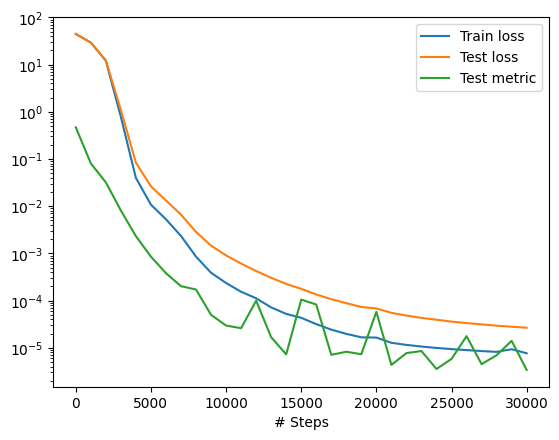

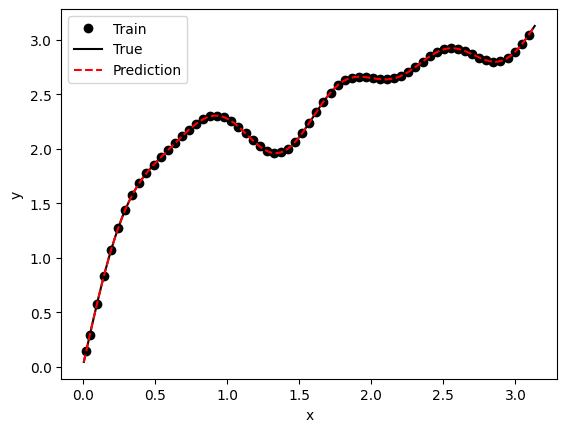

In [12]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)